# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Project
# Alzheimer’s Disease and Cognitive Impairment Prediction



---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):E109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display

from sklearn import linear_model
import copy
from sklearn import preprocessing
import sklearn.discriminant_analysis as da
from sklearn.grid_search import GridSearchCV
from sklearn import tree
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import seaborn as sns
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)



## Multiclass Alzheimer’s Disease and Cognitive Impairment Classification

In this problem, you will build a model for diagnosing disorders in a patient's cognitive impairment. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *cognitive normal* (class 0)
- having *dementia* (class 1)
- or having *MCI* (class 2). 

The data set is provided in the file `adnimerge.csv`. 

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the ADNI.



In [2]:
np.random.seed(9001)

#note: data is already sorted before loading
df = pd.read_csv('data/ADNIMERGE.csv')
df_biomark = pd.read_csv('data/BIOMARK.csv')
#df_biomark=df_biomark.sort_values(['RID','EXAMDATE'], ascending=[True, True])
print(df.shape)
print(df[0:2])
print(df_biomark.columns)
#only use some of CSF fields
#columns_csf=['Phase','RID','EXAMDATE','BICSF','BICSFAMT','BICSFVOL']
columns_csf=['Phase','RID','EXAMDATE','BILAVAMT','BILAVVOL']
#COLPROT


df_biomark_new_columns=['COLPROT','RID','EXAMDATE','BILAVAMT','BILAVVOL']
df_biomark_csf=df_biomark[columns_csf]
df_biomark_csf.columns=df_biomark_new_columns
print(df_biomark_csf.shape)
df_biomark_csf=df_biomark_csf.drop_duplicates(['RID','EXAMDATE'], keep='first')
print(df_biomark_csf.shape)
#df_biomark_csf=df_biomark_csf.sort_values(['RID','EXAMDATE'], ascending=[True, True])
print(df_biomark_csf[0:2])

(13017, 94)
   RID        PTID VISCODE  SITE COLPROT ORIGPROT  EXAMDATE DX_bl   AGE  \
0    2  011_S_0002      bl    11   ADNI1    ADNI1  9/8/2005    CN  74.3   
1    2  011_S_0002     m06    11   ADNI1    ADNI1  3/6/2006    CN  74.3   

  PTGENDER      ...       EcogSPDivatt_bl EcogSPTotal_bl   FDG_bl PIB_bl  \
0     Male      ...                   NaN            NaN  1.36926    NaN   
1     Male      ...                   NaN            NaN  1.36926    NaN   

   AV45_bl  Years_bl  Month_bl  Month  M  update_stamp  
0      NaN  0.000000   0.00000      0  0       50:48.0  
1      NaN  0.490075   5.86885      6  6       50:48.0  

[2 rows x 94 columns]
Index(['Phase', 'ID', 'RID', 'SITEID', 'VISCODE', 'VISCODE2', 'USERDATE',
       'USERDATE2', 'RECNO', 'EXAMDATE', 'BIBLOOD', 'BIURINE', 'BLREASON',
       'BLREASONO', 'BIFAST', 'BITIME', 'BIREDTIME', 'BIREDAMT', 'BIREDCENT',
       'BIREDTRNS', 'BIREDVOL', 'BIREDFROZ', 'BILAVTIME', 'BINEEDLE',
       'BILAVAMT', 'BILAVCENT', 'BILAVTRNS

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (15,16,18,19,21,22,25,26,28,29,31,33,39,49,51,57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#sorted based on RID and EXAMDATE
#df_biomark_csf=df_biomark_csf.sort_values(['RID','EXAMDATE'], ascending=[True, True])
print(df_biomark_csf[0:2])
df_biomark_csf.to_csv('data/df_biomark_csf.csv')

  COLPROT  RID  EXAMDATE  BILAVAMT  BILAVVOL
0   ADNI1    2  9/8/2005      20.0       7.0
1   ADNI1    2  3/6/2006      20.0       7.0


## 1.1 Pick some predictors from biomark.csv and merge with ADNIMERGE.csv, bio_mark predictors  : BILAVAMT, BILAVVOL


In [4]:
#merge two dataframe basedon RID and EXAMDATE
df_bio=df.merge(df_biomark_csf,on=['RID','EXAMDATE','COLPROT'], how='left')
print(df_bio[0:2])
print(df_bio.shape)

   RID        PTID VISCODE  SITE COLPROT ORIGPROT  EXAMDATE DX_bl   AGE  \
0    2  011_S_0002      bl    11   ADNI1    ADNI1  9/8/2005    CN  74.3   
1    2  011_S_0002     m06    11   ADNI1    ADNI1  3/6/2006    CN  74.3   

  PTGENDER    ...      FDG_bl PIB_bl AV45_bl  Years_bl  Month_bl  Month  M  \
0     Male    ...     1.36926    NaN     NaN  0.000000   0.00000      0  0   
1     Male    ...     1.36926    NaN     NaN  0.490075   5.86885      6  6   

   update_stamp  BILAVAMT  BILAVVOL  
0       50:48.0      20.0       7.0  
1       50:48.0      20.0       7.0  

[2 rows x 96 columns]
(13017, 96)


In [5]:
df_bio.to_csv('data/df_bio.csv')

In [6]:
#this is a test just for on RID
#datapre-precessing
x_dist=df_bio.RID.unique()
#x_dist[0:10]
temp_df=df_bio.loc[(df['RID']==2)]

temp_df_fill=copy.copy(temp_df)
temp_df_fill['DX']=temp_df['DX'].fillna(method='bfill')
#temp_df_fill['BILAVAMT']=temp_df['BILAVAMT'].fillna(method='bfill')
#temp_df_fill['BILAVVOL']=temp_df['BILAVVOL'].fillna(method='bfill')

#temp_df_fill['BICSF']=temp_df['BICSF'].fillna(method='bfill')
#temp_df_fill['BICSFAMT']=temp_df['BICSFAMT'].fillna(method='bfill')
#temp_df_fill['BICSFVOL']=temp_df['BICSFVOL'].fillna(method='bfill')


temp_df_fill.to_csv('data/temp_df_fill_bf.csv')
temp_df_fill['DX']=temp_df_fill['DX'].fillna(method='ffill')
#temp_df_fill['BILAVAMT']=temp_df['BILAVAMT'].fillna(method='ffill')
#temp_df_fill['BILAVVOL']=temp_df['BILAVVOL'].fillna(method='ffill')

#temp_df_fill['BICSF']=temp_df['BICSF'].fillna(method='ffill')
#temp_df_fill['BICSFAMT']=temp_df['BICSFAMT'].fillna(method='ffill')
#temp_df_fill['BICSFVOL']=temp_df['BICSFVOL'].fillna(method='ffill')
temp_df_fill.to_csv('data/temp_df_fill_ff.csv')
print(temp_df_fill)
temp_df_fill['DX_last']=copy.copy(temp_df_fill.DX)

#add a new field DX_change, if there is a categorical change for one participant, then it will be 1, this will be used
# to move data

temp_df_fill['DX_change']=0
col_last=temp_df_fill.shape[1]


tmp_value=temp_df_fill.iloc[temp_df_fill.shape[0]-1,temp_df_fill.shape[1]-2]
    
for i in range(0,temp_df_fill.shape[0]-1):
    #print(temp_df_fill.iloc[i,col_last-2],tmp_value)
    if (temp_df_fill.iloc[i,col_last-2]!=tmp_value):
         temp_df_fill['DX_change']=1
   
    temp_df_fill.iloc[i,col_last-2]=tmp_value

    
temp_df_fill.to_csv('data/temp_df_fill_ff_DX_last.csv')
print(temp_df_fill[0:2])
#print(temp_df_fill.DX_recent[0:10])

    RID        PTID VISCODE  SITE COLPROT ORIGPROT    EXAMDATE DX_bl   AGE  \
0     2  011_S_0002      bl    11   ADNI1    ADNI1    9/8/2005    CN  74.3   
1     2  011_S_0002     m06    11   ADNI1    ADNI1    3/6/2006    CN  74.3   
2     2  011_S_0002     m36    11   ADNI1    ADNI1   8/27/2008    CN  74.3   
3     2  011_S_0002     m60    11  ADNIGO    ADNI1   9/22/2010    CN  74.3   
4     2  011_S_0002     m66    11  ADNIGO    ADNI1    3/4/2011    CN  74.3   
5     2  011_S_0002     m72    11   ADNI2    ADNI1   9/19/2011    CN  74.3   
6     2  011_S_0002     m78    11   ADNI2    ADNI1   3/22/2012    CN  74.3   
7     2  011_S_0002     m84    11   ADNI2    ADNI1   9/26/2012    CN  74.3   
8     2  011_S_0002     m90    11   ADNI2    ADNI1   3/25/2013    CN  74.3   
9     2  011_S_0002     m96    11   ADNI2    ADNI1    9/9/2013    CN  74.3   
10    2  011_S_0002    m102    11   ADNI2    ADNI1   3/17/2014    CN  74.3   
11    2  011_S_0002    m108    11   ADNI2    ADNI1  10/13/2014  

In [7]:
#create DX_last, DX_change, backfill/forward fill to get DX_last, and BILAVAMT, BILAVVOL, 
x_dist=df_bio.RID.unique()
#x_dist[0:10]
df_fill=pd.DataFrame()
count=1
for i in x_dist:
    temp_df=pd.DataFrame()
    temp_df_fill=pd.DataFrame()
    
    temp_df=df_bio.loc[(df['RID']==i)]
 
    temp_df_fill=copy.copy(temp_df)
    temp_df_fill['DX']=temp_df['DX'].fillna(method='bfill')
    #temp_df_fill['BILAVAMT']=temp_df['BILAVAMT'].fillna(method='bfill')
    #temp_df_fill['BILAVVOL']=temp_df['BILAVVOL'].fillna(method='bfill')
  
    temp_df_fill['DX']=temp_df['DX'].fillna(method='ffill')
    #temp_df_fill['BILAVAMT']=temp_df['BILAVAMT'].fillna(method='ffill')
    #temp_df_fill['BILAVVOL']=temp_df['BILAVVOL'].fillna(method='ffill')
  

    temp_df_fill['DX_last']=copy.copy(temp_df_fill.DX)
    temp_df_fill['DX_change']=0
  
    if(temp_df_fill.shape[0]>1):
        col_last=df_fill.shape[1]
        tmp_value=temp_df_fill.iloc[temp_df_fill.shape[0]-1,temp_df_fill.shape[1]-2]

        for i in range(0,temp_df_fill.shape[0]-1):
            if (temp_df_fill.iloc[i,col_last-2]!=tmp_value):
                 temp_df_fill['DX_change']=1
            temp_df_fill.iloc[i,col_last-2]=tmp_value

    if (count==1):
        df_fill=temp_df_fill
    else:
        df_fill=pd.concat([df_fill, temp_df_fill], axis=0)
    count=count+1
    
    
temp_df_fill.to_csv('data/temp_df_fill_ff_DX_last.csv')


df_fill.to_csv('data/df_fill_DX_change_bio.csv')

print(df_fill[0:2])

   RID        PTID VISCODE  SITE COLPROT ORIGPROT  EXAMDATE DX_bl   AGE  \
0    2  011_S_0002      bl    11   ADNI1    ADNI1  9/8/2005    CN  74.3   
1    2  011_S_0002     m06    11   ADNI1    ADNI1  3/6/2006    CN  74.3   

  PTGENDER    ...      AV45_bl  Years_bl Month_bl Month  M  update_stamp  \
0     Male    ...          NaN  0.000000  0.00000     0  0       50:48.0   
1     Male    ...          NaN  0.490075  5.86885     6  6       50:48.0   

   BILAVAMT  BILAVVOL  DX_last  DX_change  
0      20.0       7.0       CN          1  
1      20.0       7.0       CN          1  

[2 rows x 98 columns]


In [8]:
print(df_fill.columns)

Index(['RID', 'PTID', 'VISCODE', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION',
       'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
       'MidTemp', 'ICV', 'DX', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl',
       'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl',
       'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'FAQ_bl',
       'FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl',
       'WholeBrain_bl', 'Entorhinal_bl

In [9]:
#drop columns that doesnt have relevent or enough data
column_drop_clean=['PIB', 'AV45','MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal','EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl',
       'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl',
       'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'FAQ_bl',
       'FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl',
       'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl',
       'MOCA_bl', 'EcogPtMem_bl', 'EcogPtLang_bl', 'EcogPtVisspat_bl',
       'EcogPtPlan_bl', 'EcogPtOrgan_bl', 'EcogPtDivatt_bl', 'EcogPtTotal_bl',
       'EcogSPMem_bl', 'EcogSPLang_bl', 'EcogSPVisspat_bl', 'EcogSPPlan_bl',
       'EcogSPOrgan_bl', 'EcogSPDivatt_bl', 'EcogSPTotal_bl', 'FDG_bl',
       'PIB_bl', 'AV45_bl', 'Years_bl', 'Month_bl', 'Month', 'M',
       'update_stamp']

df_fill_test=df_fill.drop(column_drop_clean, axis=1)
df_fill_test.to_csv('data/df_fill_drop_bio.csv')

print(df_fill_test.shape)

(13017, 39)


In [10]:

df_fill_drop=copy.copy(df_fill_test)
df_fill_drop=df_fill_drop.dropna()
#also drop those that with DX_change=1
df_fill_drop=df_fill_drop.loc[(df_fill_drop['DX_change']==0)]
df_fill_drop.to_csv('data/df_fill_drop_DX_change_bio.csv')
print(df_fill_drop.shape)

(911, 39)


In [11]:
#drop some columns


df_fill_drop_clean=df_fill_drop.drop('PTID', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('VISCODE', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('SITE', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('ORIGPROT', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('EXAMDATE', axis=1)

print(df_fill_drop_clean[0:2])


    RID COLPROT DX_bl   AGE PTGENDER  PTEDUCAT         PTETHCAT PTRACCAT  \
14    3   ADNI1    AD  81.3     Male        18  Not Hisp/Latino    White   
15    3   ADNI1    AD  81.3     Male        18  Not Hisp/Latino    White   

    PTMARRY  APOE4    ...      WholeBrain  Entorhinal  Fusiform  MidTemp  \
14  Married    1.0    ...       1129830.0      1791.0   15506.0  18422.0   
15  Married    1.0    ...       1100060.0      2427.0   14400.0  16972.0   

          ICV        DX  BILAVAMT  BILAVVOL   DX_last  DX_change  
14  1920690.0  Dementia      20.0       8.0  Dementia          0  
15  1906430.0  Dementia      20.0       9.0  Dementia          0  

[2 rows x 34 columns]


In [12]:
print(df_fill_drop_clean.columns)

Index(['RID', 'COLPROT', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'BILAVAMT', 'BILAVVOL', 'DX_last', 'DX_change'],
      dtype='object')


## 1.2: preliminary EDA

In [13]:
#adding dummy variables
#indentify columns that will be dropped after dummy variable were created, numerical columns that will be scaled, etc.
categorical_columns_drop = ['DX_bl', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT','PTMARRY','FLDSTRENG',
                            'FSVERSION','DX','DX_last','DX_change']

categorical_columns = ['PTGENDER_cat', 'PTEDUCAT_cat', 'PTETHCAT_cat', 'PTRACCAT_cat','PTMARRY_cat'
                       ,'FLDSTRENG_cat','FSVERSION_cat']


numerical_columns = ['AGE', 'APOE4', 'FDG', 'CDRSB','ADAS11','ADAS13','MMSE',
                     'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ',
                     'Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','BILAVAMT', 'BILAVVOL']

In [15]:

df_fill_drop_clean["PTGENDER"] = df_fill_drop_clean["PTGENDER"].astype('category')
df_fill_drop_clean["PTGENDER_cat"] = df_fill_drop_clean["PTGENDER"].cat.codes

df_fill_drop_clean["PTEDUCAT"] = df_fill_drop_clean["PTEDUCAT"].astype('category')
df_fill_drop_clean["PTEDUCAT_cat"] = df_fill_drop_clean["PTEDUCAT"].cat.codes

df_fill_drop_clean["PTETHCAT"] = df_fill_drop_clean["PTETHCAT"].astype('category')
df_fill_drop_clean["PTETHCAT_cat"] = df_fill_drop_clean["PTETHCAT"].cat.codes

df_fill_drop_clean["PTRACCAT"] = df_fill_drop_clean["PTRACCAT"].astype('category')
df_fill_drop_clean["PTRACCAT_cat"] = df_fill_drop_clean["PTRACCAT"].cat.codes

df_fill_drop_clean["PTMARRY"] = df_fill_drop_clean["PTMARRY"].astype('category')
df_fill_drop_clean["PTMARRY_cat"] = df_fill_drop_clean["PTMARRY"].cat.codes

df_fill_drop_clean["FLDSTRENG"] = df_fill_drop_clean["FLDSTRENG"].astype('category')
df_fill_drop_clean["FLDSTRENG_cat"] = df_fill_drop_clean["FLDSTRENG"].cat.codes


df_fill_drop_clean["FSVERSION"] = df_fill_drop_clean["FSVERSION"].astype('category')
df_fill_drop_clean["FSVERSION_cat"] = df_fill_drop_clean["FSVERSION"].cat.codes

df_fill_drop_clean["DX_last"] = df_fill_drop_clean["DX_last"].astype('category')
df_fill_drop_clean["DX_last_cat"] = df_fill_drop_clean["DX_last"].cat.codes

print(df_fill_drop_clean[0:2])

    RID COLPROT DX_bl   AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
14    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   
15    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   

    PTMARRY  APOE4     ...        DX_last  DX_change  PTGENDER_cat  \
14  Married    1.0     ...       Dementia          0             1   
15  Married    1.0     ...       Dementia          0             1   

    PTEDUCAT_cat  PTETHCAT_cat  PTRACCAT_cat  PTMARRY_cat  FLDSTRENG_cat  \
14            12             1             5            1              0   
15            12             1             5            1              0   

    FSVERSION_cat  DX_last_cat  
14              1            1  
15              1            1  

[2 rows x 42 columns]


In [16]:
df_fill_drop_clean.to_csv('data/df_fill_drop_clean.csv')

In [17]:
df_fill_drop_clean.dtypes

RID                         int64
COLPROT                    object
DX_bl                      object
AGE                       float64
PTGENDER                 category
PTEDUCAT                 category
PTETHCAT                 category
PTRACCAT                 category
PTMARRY                  category
APOE4                     float64
FDG                       float64
CDRSB                     float64
ADAS11                    float64
ADAS13                    float64
MMSE                      float64
RAVLT_immediate           float64
RAVLT_learning            float64
RAVLT_forgetting          float64
RAVLT_perc_forgetting     float64
FAQ                       float64
FLDSTRENG                category
FSVERSION                category
Ventricles                float64
Hippocampus               float64
WholeBrain                float64
Entorhinal                float64
Fusiform                  float64
MidTemp                   float64
ICV                       float64
DX            

## 1.3: adding dummy variables

In [18]:

df_fill_drop_clean_dummy = pd.get_dummies(df_fill_drop_clean, columns=categorical_columns, drop_first=True)
print(df_fill_drop_clean_dummy[0:2])
print(df_fill_drop_clean_dummy.shape)


    RID COLPROT DX_bl   AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
14    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   
15    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   

    PTMARRY  APOE4       ...         PTRACCAT_cat_2  PTRACCAT_cat_3  \
14  Married    1.0       ...                      0               0   
15  Married    1.0       ...                      0               0   

    PTRACCAT_cat_4  PTRACCAT_cat_5  PTMARRY_cat_1  PTMARRY_cat_2  \
14               0               1              1              0   
15               0               1              1              0   

    PTMARRY_cat_3  PTMARRY_cat_4  FLDSTRENG_cat_1  FSVERSION_cat_1  
14              0              0                0                1  
15              0              0                0                1  

[2 rows x 63 columns]
(911, 63)


In [19]:
print(df_fill_drop_clean.columns)

Index(['RID', 'COLPROT', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'BILAVAMT', 'BILAVVOL', 'DX_last', 'DX_change', 'PTGENDER_cat',
       'PTEDUCAT_cat', 'PTETHCAT_cat', 'PTRACCAT_cat', 'PTMARRY_cat',
       'FLDSTRENG_cat', 'FSVERSION_cat', 'DX_last_cat'],
      dtype='object')


## 1.3: split data into train/test and scale data

In [20]:
#split data between train and test
np.random.seed(9001)

df_ADNI=df_fill_drop_clean_dummy.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNI1']
print(df_ADNI.shape,df_ADNI[0:2])
msk = np.random.rand(len(df_ADNI)) < 0.5

data_train_ADNI=df_fill_drop_clean.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNI1']
data_train_EDA=data_train_ADNI[msk]

data_train_raw = df_ADNI[msk]
data_test_raw = df_ADNI[~msk]


(600, 63)     RID COLPROT DX_bl   AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
14    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   
15    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   

    PTMARRY  APOE4       ...         PTRACCAT_cat_2  PTRACCAT_cat_3  \
14  Married    1.0       ...                      0               0   
15  Married    1.0       ...                      0               0   

    PTRACCAT_cat_4  PTRACCAT_cat_5  PTMARRY_cat_1  PTMARRY_cat_2  \
14               0               1              1              0   
15               0               1              1              0   

    PTMARRY_cat_3  PTMARRY_cat_4  FLDSTRENG_cat_1  FSVERSION_cat_1  
14              0              0                0                1  
15              0              0                0                1  

[2 rows x 63 columns]


In [21]:
#get test data as ADNI2 and ADNIGO

df_ADNI2=df_fill_drop_clean_dummy.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNI2']
df_ADNIGO=df_fill_drop_clean_dummy.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNIGO']

#scale the data
mean = data_train_raw[numerical_columns].mean()
std = data_train_raw[numerical_columns].std()

data_train_raw[numerical_columns] = (data_train_raw[numerical_columns] - mean)/std
data_test_raw[numerical_columns] = (data_test_raw[numerical_columns] - mean)/std

df_ADNI2[numerical_columns] = (df_ADNI2[numerical_columns] - mean)/std
df_ADNIGO[numerical_columns] = (df_ADNIGO[numerical_columns] - mean)/std

print(df_ADNI2.shape,df_ADNIGO.shape)

print(data_train_raw[0:2])
print(data_test_raw[0:2])



C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


(260, 63) (51, 63)
    RID COLPROT DX_bl       AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
14    3   ADNI1    AD  1.011503     Male       18  Not Hisp/Latino    White   
29    5   ADNI1    CN -0.177295     Male       16  Not Hisp/Latino    White   

    PTMARRY     APOE4       ...         PTRACCAT_cat_2  PTRACCAT_cat_3  \
14  Married  0.870366       ...                      0               0   
29  Married -0.796413       ...                      0               0   

    PTRACCAT_cat_4  PTRACCAT_cat_5  PTMARRY_cat_1  PTMARRY_cat_2  \
14               0               1              1              0   
29               0               1              1              0   

    PTMARRY_cat_3  PTMARRY_cat_4  FLDSTRENG_cat_1  FSVERSION_cat_1  
14              0              0                0                1  
29              0              0                0                1  

[2 rows x 63 columns]
    RID COLPROT DX_bl       AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
15    

## 2.1 EDA


In [22]:
print(data_train_EDA.columns)

Index(['RID', 'COLPROT', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'BILAVAMT', 'BILAVVOL', 'DX_last', 'DX_change', 'PTGENDER_cat',
       'PTEDUCAT_cat', 'PTETHCAT_cat', 'PTRACCAT_cat', 'PTMARRY_cat',
       'FLDSTRENG_cat', 'FSVERSION_cat', 'DX_last_cat'],
      dtype='object')


In [23]:
print(pd.DataFrame(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0])[0:2])

    RID COLPROT DX_bl   AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
29    5   ADNI1    CN  73.7     Male       16  Not Hisp/Latino    White   
67   14   ADNI1    CN  78.5   Female       12      Hisp/Latino    White   

     PTMARRY  APOE4     ...       DX_last  DX_change  PTGENDER_cat  \
29   Married    0.0     ...            CN          0             1   
67  Divorced    0.0     ...            CN          0             0   

    PTEDUCAT_cat  PTETHCAT_cat  PTRACCAT_cat  PTMARRY_cat  FLDSTRENG_cat  \
29            10             1             5            1              0   
67             6             0             5            0              0   

    FSVERSION_cat  DX_last_cat  
29              1            0  
67              1            0  

[2 rows x 42 columns]


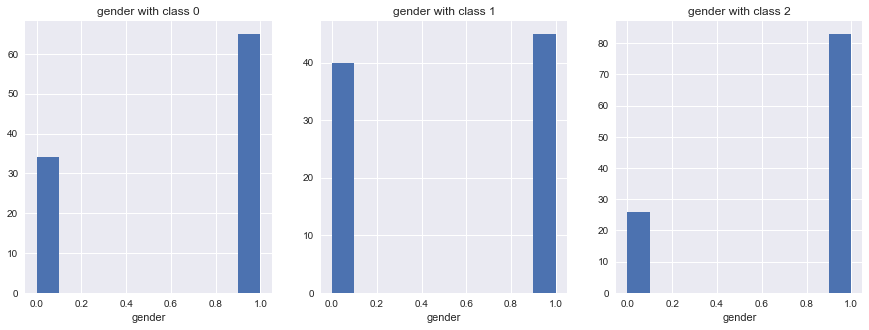

In [24]:
#gender
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTGENDER_cat'])

ax[0].set_xlabel('gender')

ax[0].set_title('gender with class 0')
                 
ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTGENDER_cat'])
ax[1].set_xlabel('gender')

ax[1].set_title('gender with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTGENDER_cat'])
ax[2].set_xlabel('gender')

ax[2].set_title('gender with class 2')

plt.show()

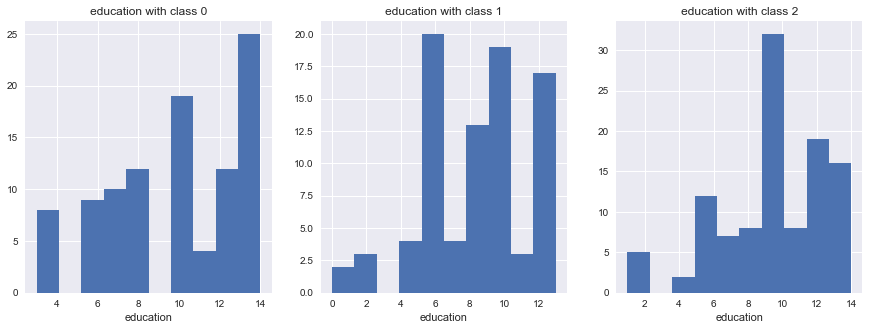

In [25]:
#education
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTEDUCAT_cat'])

ax[0].set_xlabel('education')

ax[0].set_title('education with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTEDUCAT_cat'])
ax[1].set_xlabel('education')

ax[1].set_title('education with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTEDUCAT_cat'])
ax[2].set_xlabel('education')

ax[2].set_title('education with class 2')

plt.show()

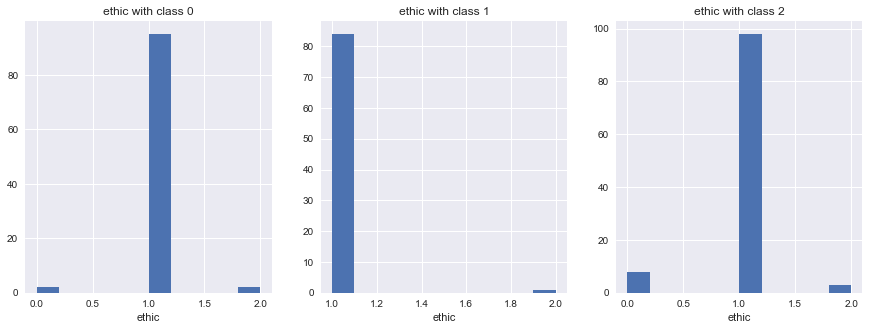

In [26]:
#ethic
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTETHCAT_cat'])

ax[0].set_xlabel('ethic')

ax[0].set_title('ethic with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTETHCAT_cat'])
ax[1].set_xlabel('ethic')

ax[1].set_title('ethic with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTETHCAT_cat'])
ax[2].set_xlabel('ethic')

ax[2].set_title('ethic with class 2')

plt.show()

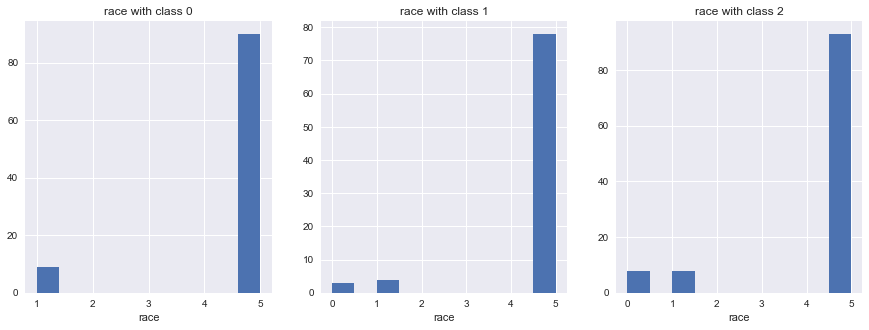

In [27]:
#race
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTRACCAT_cat'])

ax[0].set_xlabel('race')

ax[0].set_title('race with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTRACCAT_cat'])
ax[1].set_xlabel('race')

ax[1].set_title('race with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTRACCAT_cat'])
ax[2].set_xlabel('race')

ax[2].set_title('race with class 2')

plt.show()

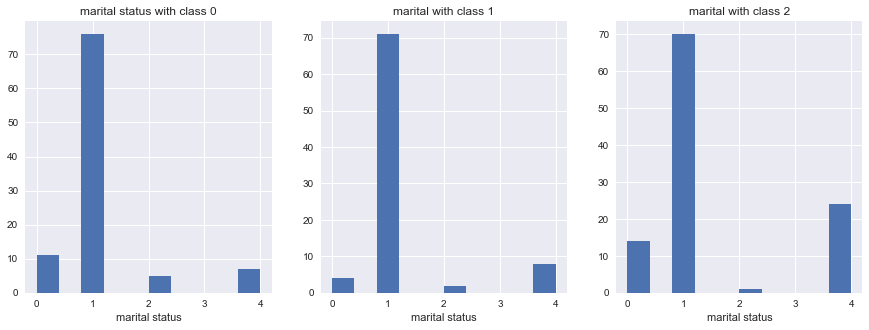

In [28]:
#marital status
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTMARRY_cat'])

ax[0].set_xlabel('marital status')

ax[0].set_title('marital status with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTMARRY_cat'])
ax[1].set_xlabel('marital status')

ax[1].set_title('marital with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTMARRY_cat'])
ax[2].set_xlabel('marital status')

ax[2].set_title('marital with class 2')

plt.show()

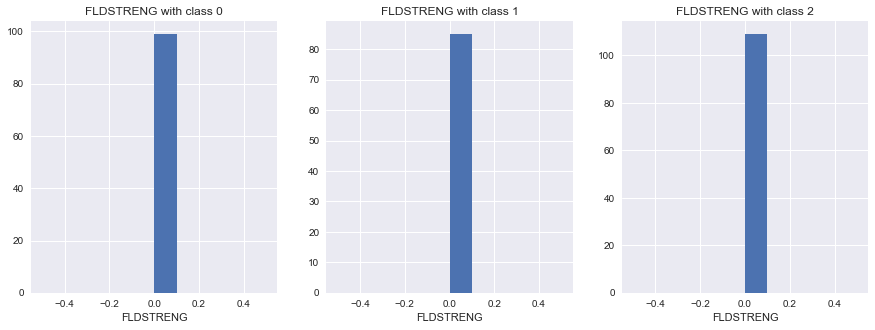

In [29]:
#marital status
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['FLDSTRENG_cat'])

ax[0].set_xlabel('FLDSTRENG')

ax[0].set_title('FLDSTRENG with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['FLDSTRENG_cat'])
ax[1].set_xlabel('FLDSTRENG')

ax[1].set_title('FLDSTRENG with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['FLDSTRENG_cat'])
ax[2].set_xlabel('FLDSTRENG')

ax[2].set_title('FLDSTRENG with class 2')

plt.show()

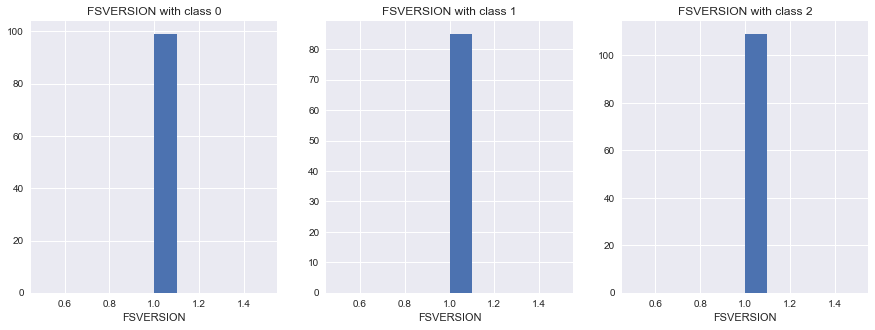

In [30]:
#FSVERSION_cat
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['FSVERSION_cat'])

ax[0].set_xlabel('FSVERSION')

ax[0].set_title('FSVERSION with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['FSVERSION_cat'])
ax[1].set_xlabel('FSVERSION')

ax[1].set_title('FSVERSION with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['FSVERSION_cat'])
ax[2].set_xlabel('FSVERSION')

ax[2].set_title('FSVERSION with class 2')

plt.show()

In [31]:
data_train=copy.copy(data_train_raw.drop('RID',axis=1))
data_train=data_train.drop('COLPROT',axis=1)

data_test=data_test_raw.drop('RID',axis=1)
data_test=data_test.drop('COLPROT',axis=1)

df_ADNI2=df_ADNI2.drop('RID',axis=1)
df_ADNI2=df_ADNI2.drop('COLPROT',axis=1)

df_ADNIGO=df_ADNIGO.drop('RID',axis=1)
df_ADNIGO=df_ADNIGO.drop('COLPROT',axis=1)



In [32]:
data_train.to_csv('data/data_train.csv')
data_test.to_csv('data/data_test.csv')

df_ADNI2.to_csv('data/df_ADNI2.csv')
df_ADNIGO.to_csv('data/df_ADNIGO.csv')


In [33]:
print(data_train.columns)
print(data_train_raw.columns)

Index(['DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'BILAVAMT', 'BILAVVOL', 'DX_last', 'DX_change', 'DX_last_cat',
       'PTGENDER_cat_1', 'PTEDUCAT_cat_1', 'PTEDUCAT_cat_2', 'PTEDUCAT_cat_3',
       'PTEDUCAT_cat_4', 'PTEDUCAT_cat_5', 'PTEDUCAT_cat_6', 'PTEDUCAT_cat_7',
       'PTEDUCAT_cat_8', 'PTEDUCAT_cat_9', 'PTEDUCAT_cat_10',
       'PTEDUCAT_cat_11', 'PTEDUCAT_cat_12', 'PTEDUCAT_cat_13',
       'PTEDUCAT_cat_14', 'PTETHCAT_cat_1', 'PTETHCAT_cat_2', 'PTRACCAT_cat_1',
       'PTRACCAT_cat_2', 'PTRACCAT_cat_3', 'PTRACCAT_cat_4', 'PTRACCAT_cat_5',
       'PTMARRY_cat_1', 'PTMARRY_cat_2', 'PTMARRY_cat_3', 'PTMARRY_cat_4',
       'FLDSTRENG_cat_1', 'FSVERSION_cat_

In [34]:
#drop those categorical predictors as they has been converted to dummy variable
print(categorical_columns_drop)
data_train=data_train.drop(categorical_columns_drop,axis=1)
data_test=data_test.drop(categorical_columns_drop,axis=1)
df_ADNI2=df_ADNI2.drop(categorical_columns_drop,axis=1)
df_ADNIGO=df_ADNIGO.drop(categorical_columns_drop,axis=1)



['DX_bl', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'FLDSTRENG', 'FSVERSION', 'DX', 'DX_last', 'DX_change']


In [35]:
print(data_train.head())
print(data_train.columns)
print(data_train.describe())

         AGE     APOE4       FDG     CDRSB    ADAS11    ADAS13      MMSE  \
14  1.011503  0.870366 -0.609706  0.960857  1.277517  1.120350 -1.618243   
29 -0.177295 -0.796413  1.063369 -0.846404 -0.567811 -0.612981  0.657654   
62 -0.146011  0.870366 -1.393862  1.161664  0.949049  1.062284  0.404777   
67  0.573525 -0.796413  0.860154 -0.846404 -0.444789 -0.612981  0.910532   
68  0.573525 -0.796413  0.722077 -0.645597 -0.731430 -0.988247  0.657654   

    RAVLT_immediate  RAVLT_learning  RAVLT_forgetting       ...         \
14        -0.803530       -1.009804          0.079621       ...          
29         0.264545        0.105294         -0.369013       ...          
62        -1.337568       -1.381503         -0.369013       ...          
67         0.493419        1.220391          0.528255       ...          
68         0.340836        0.848692         -1.266280       ...          

    PTRACCAT_cat_2  PTRACCAT_cat_3  PTRACCAT_cat_4  PTRACCAT_cat_5  \
14               0          

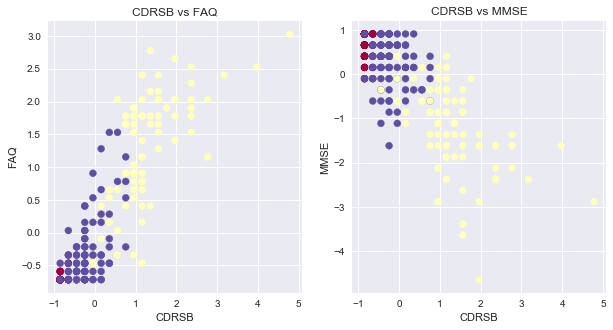

In [36]:
#scatter plot

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

colorMap = plt.get_cmap('Spectral')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['CDRSB']],data_train[['FAQ']],alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('CDRSB')
ax[0].set_ylabel('FAQ')
ax[0].set_title('CDRSB vs FAQ')
                 
ax[1].scatter(data_train[['CDRSB']],data_train[['MMSE']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
ax[1].set_xlabel('CDRSB')
ax[1].set_ylabel('MMSE')
ax[1].set_title('CDRSB vs MMSE')
plt.show()

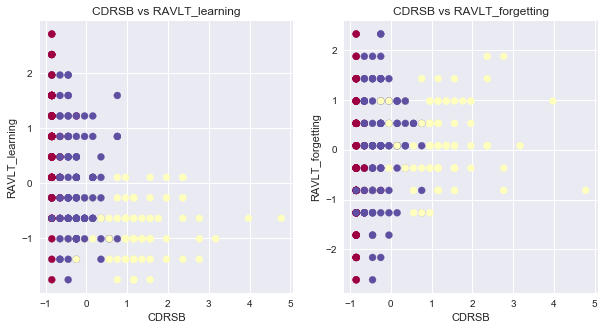

In [37]:
#scatter plot
#BIOMARKER data: CDRSB, FAQ, MMSE
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

colorMap = plt.get_cmap('Spectral')


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['CDRSB']],data_train[['RAVLT_learning']],alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('CDRSB')
ax[0].set_ylabel('RAVLT_learning')
ax[0].set_title('CDRSB vs RAVLT_learning')
                 
ax[1].scatter(data_train[['CDRSB']],data_train[['RAVLT_forgetting']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
ax[1].set_xlabel('CDRSB')
ax[1].set_ylabel('RAVLT_forgetting')
ax[1].set_title('CDRSB vs RAVLT_forgetting')
plt.show()

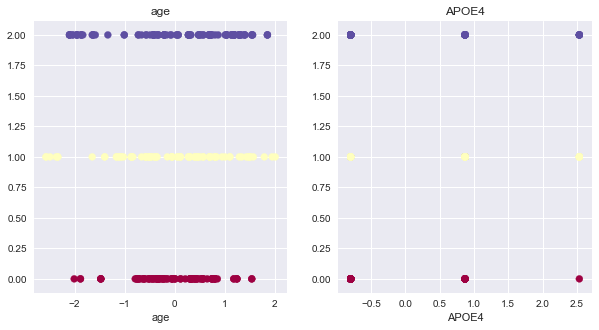

In [38]:
#scatter plot


colorMap = plt.get_cmap('Spectral')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['AGE']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('age')
ax[0].set_title('age')
                 
ax[1].scatter(data_train[['APOE4']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)

ax[1].set_xlabel('APOE4')
ax[1].set_title('APOE4')
plt.show()

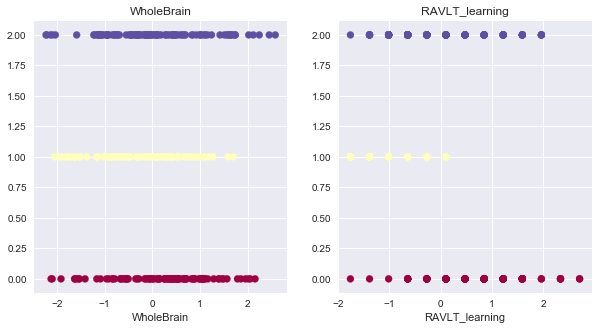

In [39]:
#scatter plot
#WholeBrain
colorMap = plt.get_cmap('Spectral')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['WholeBrain']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('WholeBrain')
ax[0].set_title('WholeBrain')

#RAVLT_learning
ax[1].scatter(data_train[['RAVLT_learning']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)

ax[1].set_xlabel('RAVLT_learning')
ax[1].set_title('RAVLT_learning')
plt.show()

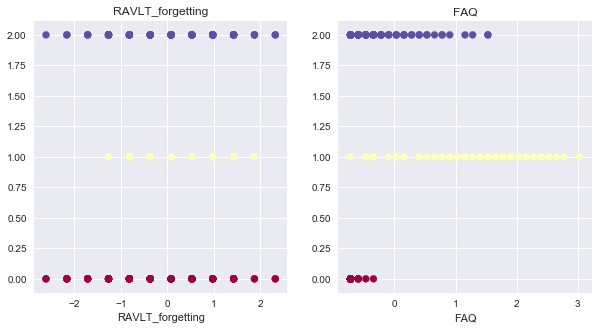

In [40]:
#scatter plot
#RAVLT_forgetting
colorMap = plt.get_cmap('Spectral')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['RAVLT_forgetting']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('RAVLT_forgetting')
ax[0].set_title('RAVLT_forgetting')

#FAQ
ax[1].scatter(data_train[['FAQ']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)

ax[1].set_xlabel('FAQ')
ax[1].set_title('FAQ')
plt.show()

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


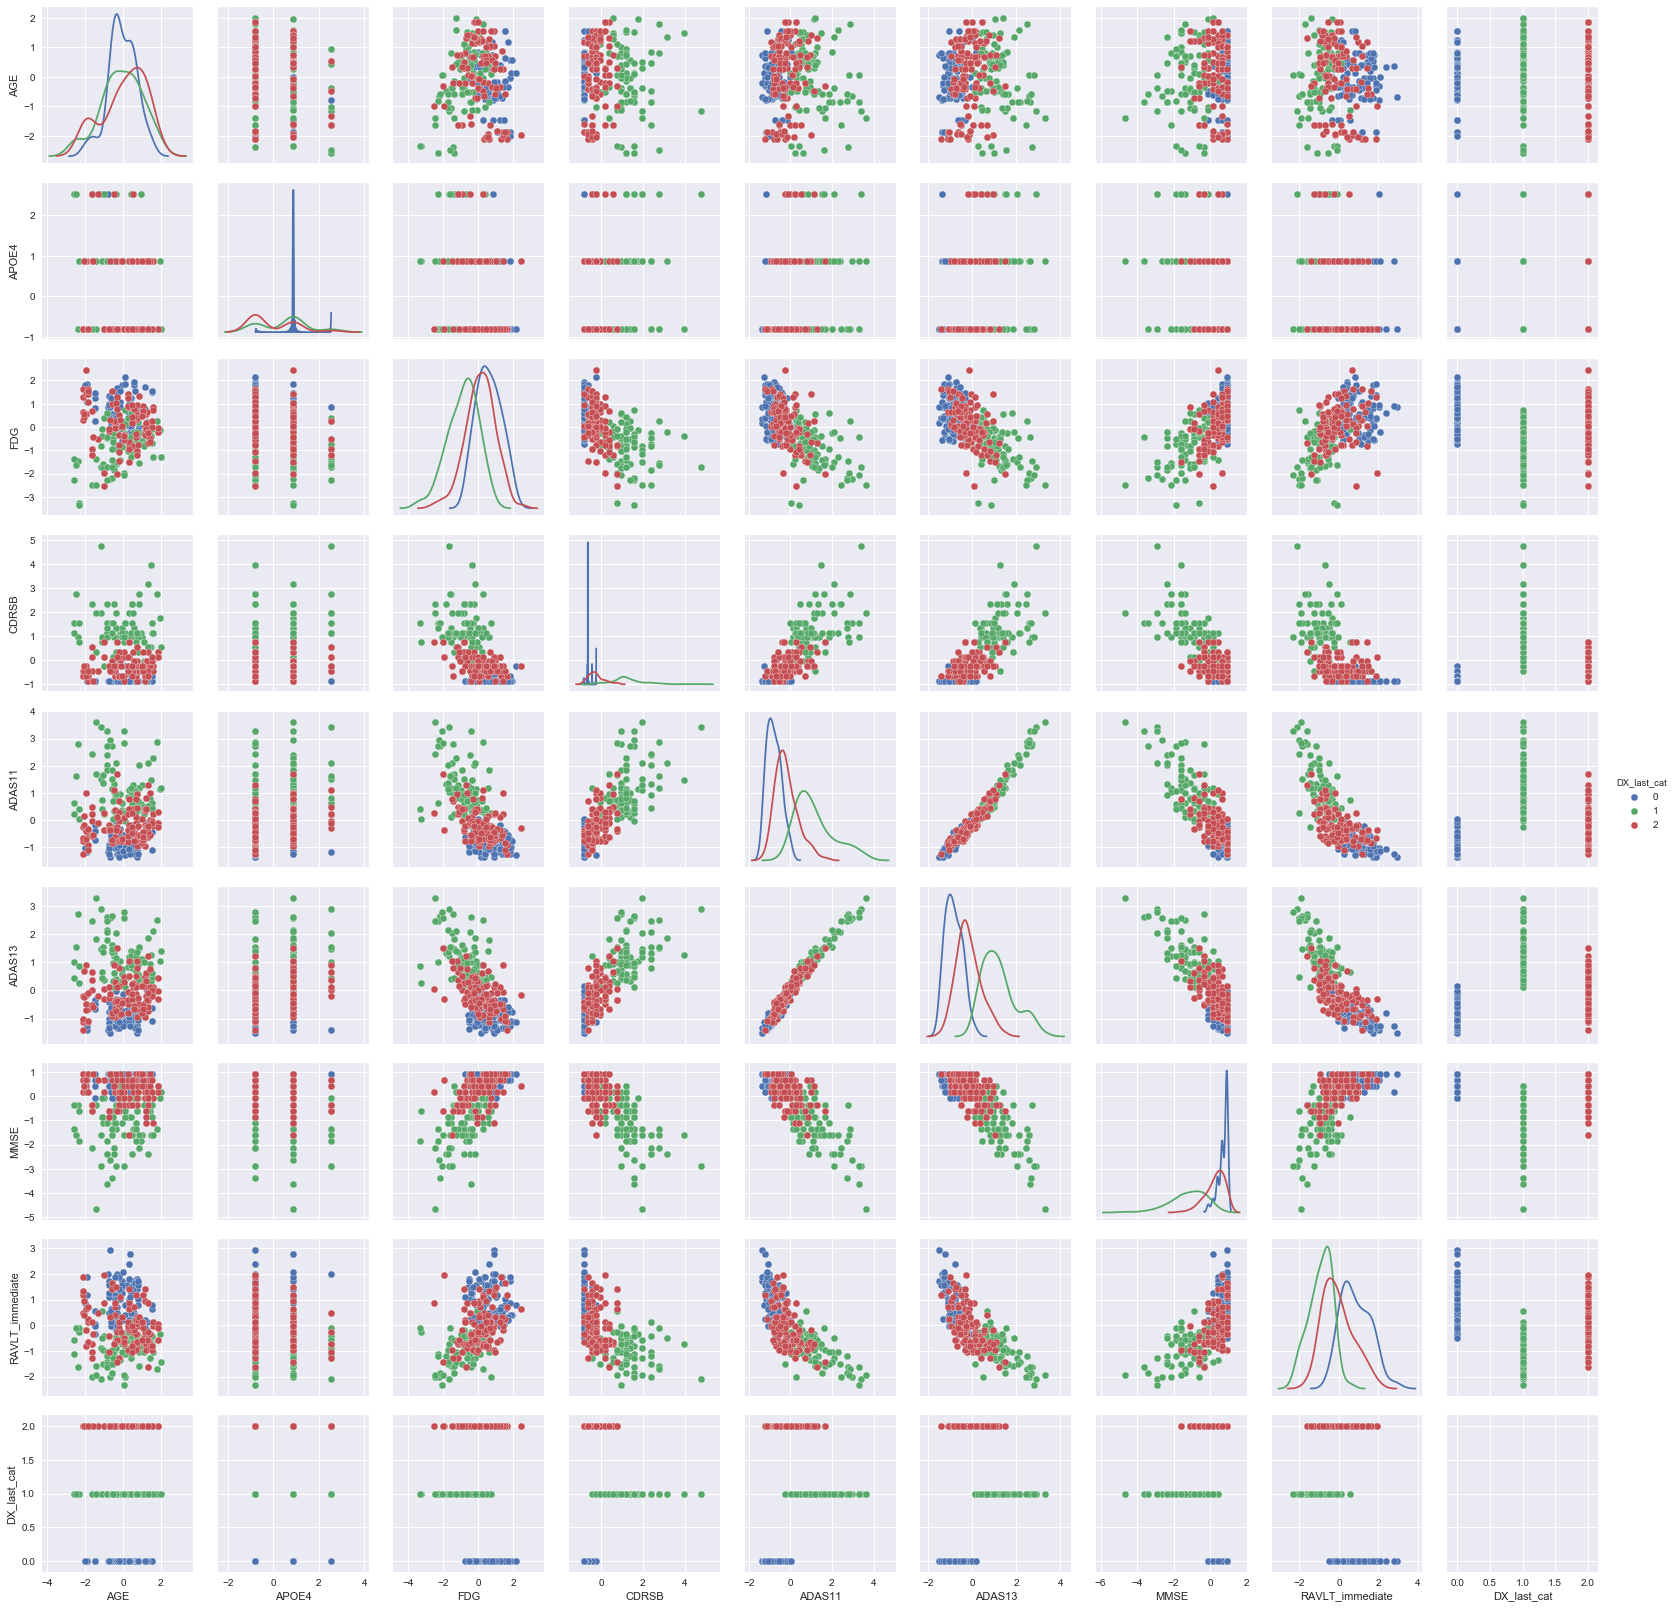

In [41]:
numerical_columns_plot_1= ['AGE', 'APOE4', 'FDG', 'CDRSB','ADAS11','ADAS13','MMSE','RAVLT_immediate','DX_last_cat']
sns.pairplot(data_train, vars=numerical_columns_plot_1, hue="DX_last_cat", size=2.5, diag_kind='kde');

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


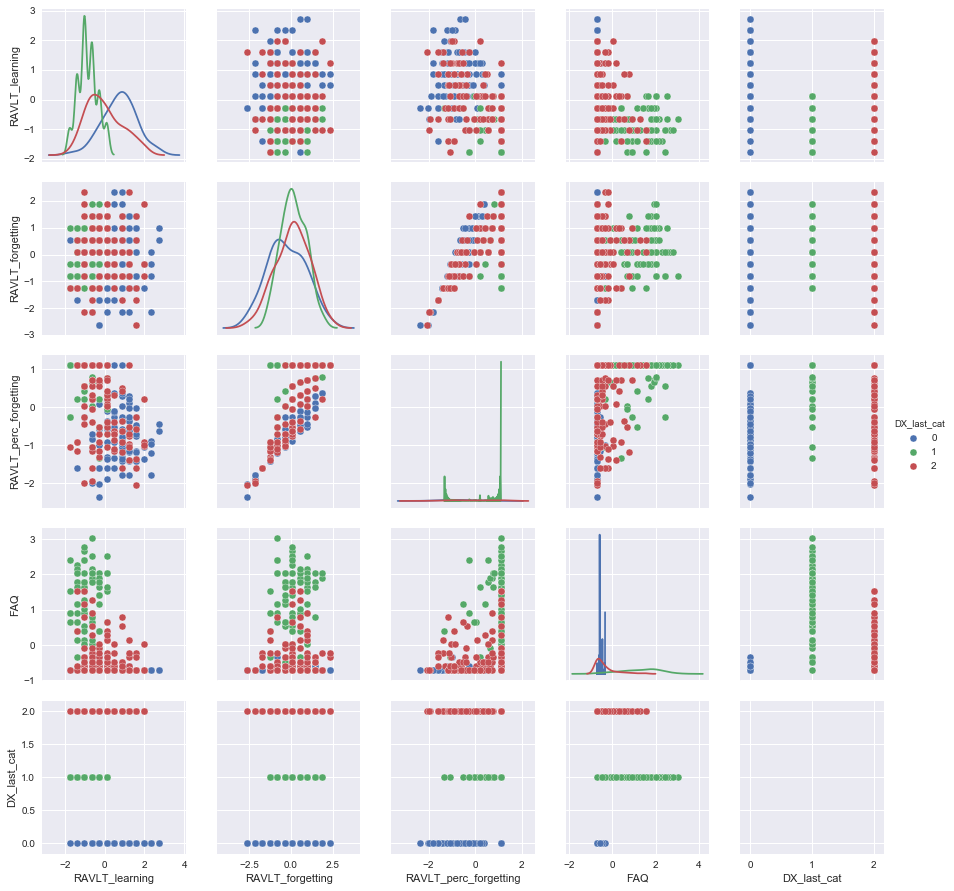

In [42]:
numerical_columns_plot_2= ['RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ','DX_last_cat']
sns.pairplot(data_train, vars=numerical_columns_plot_2, hue="DX_last_cat", size=2.5, diag_kind='kde');

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


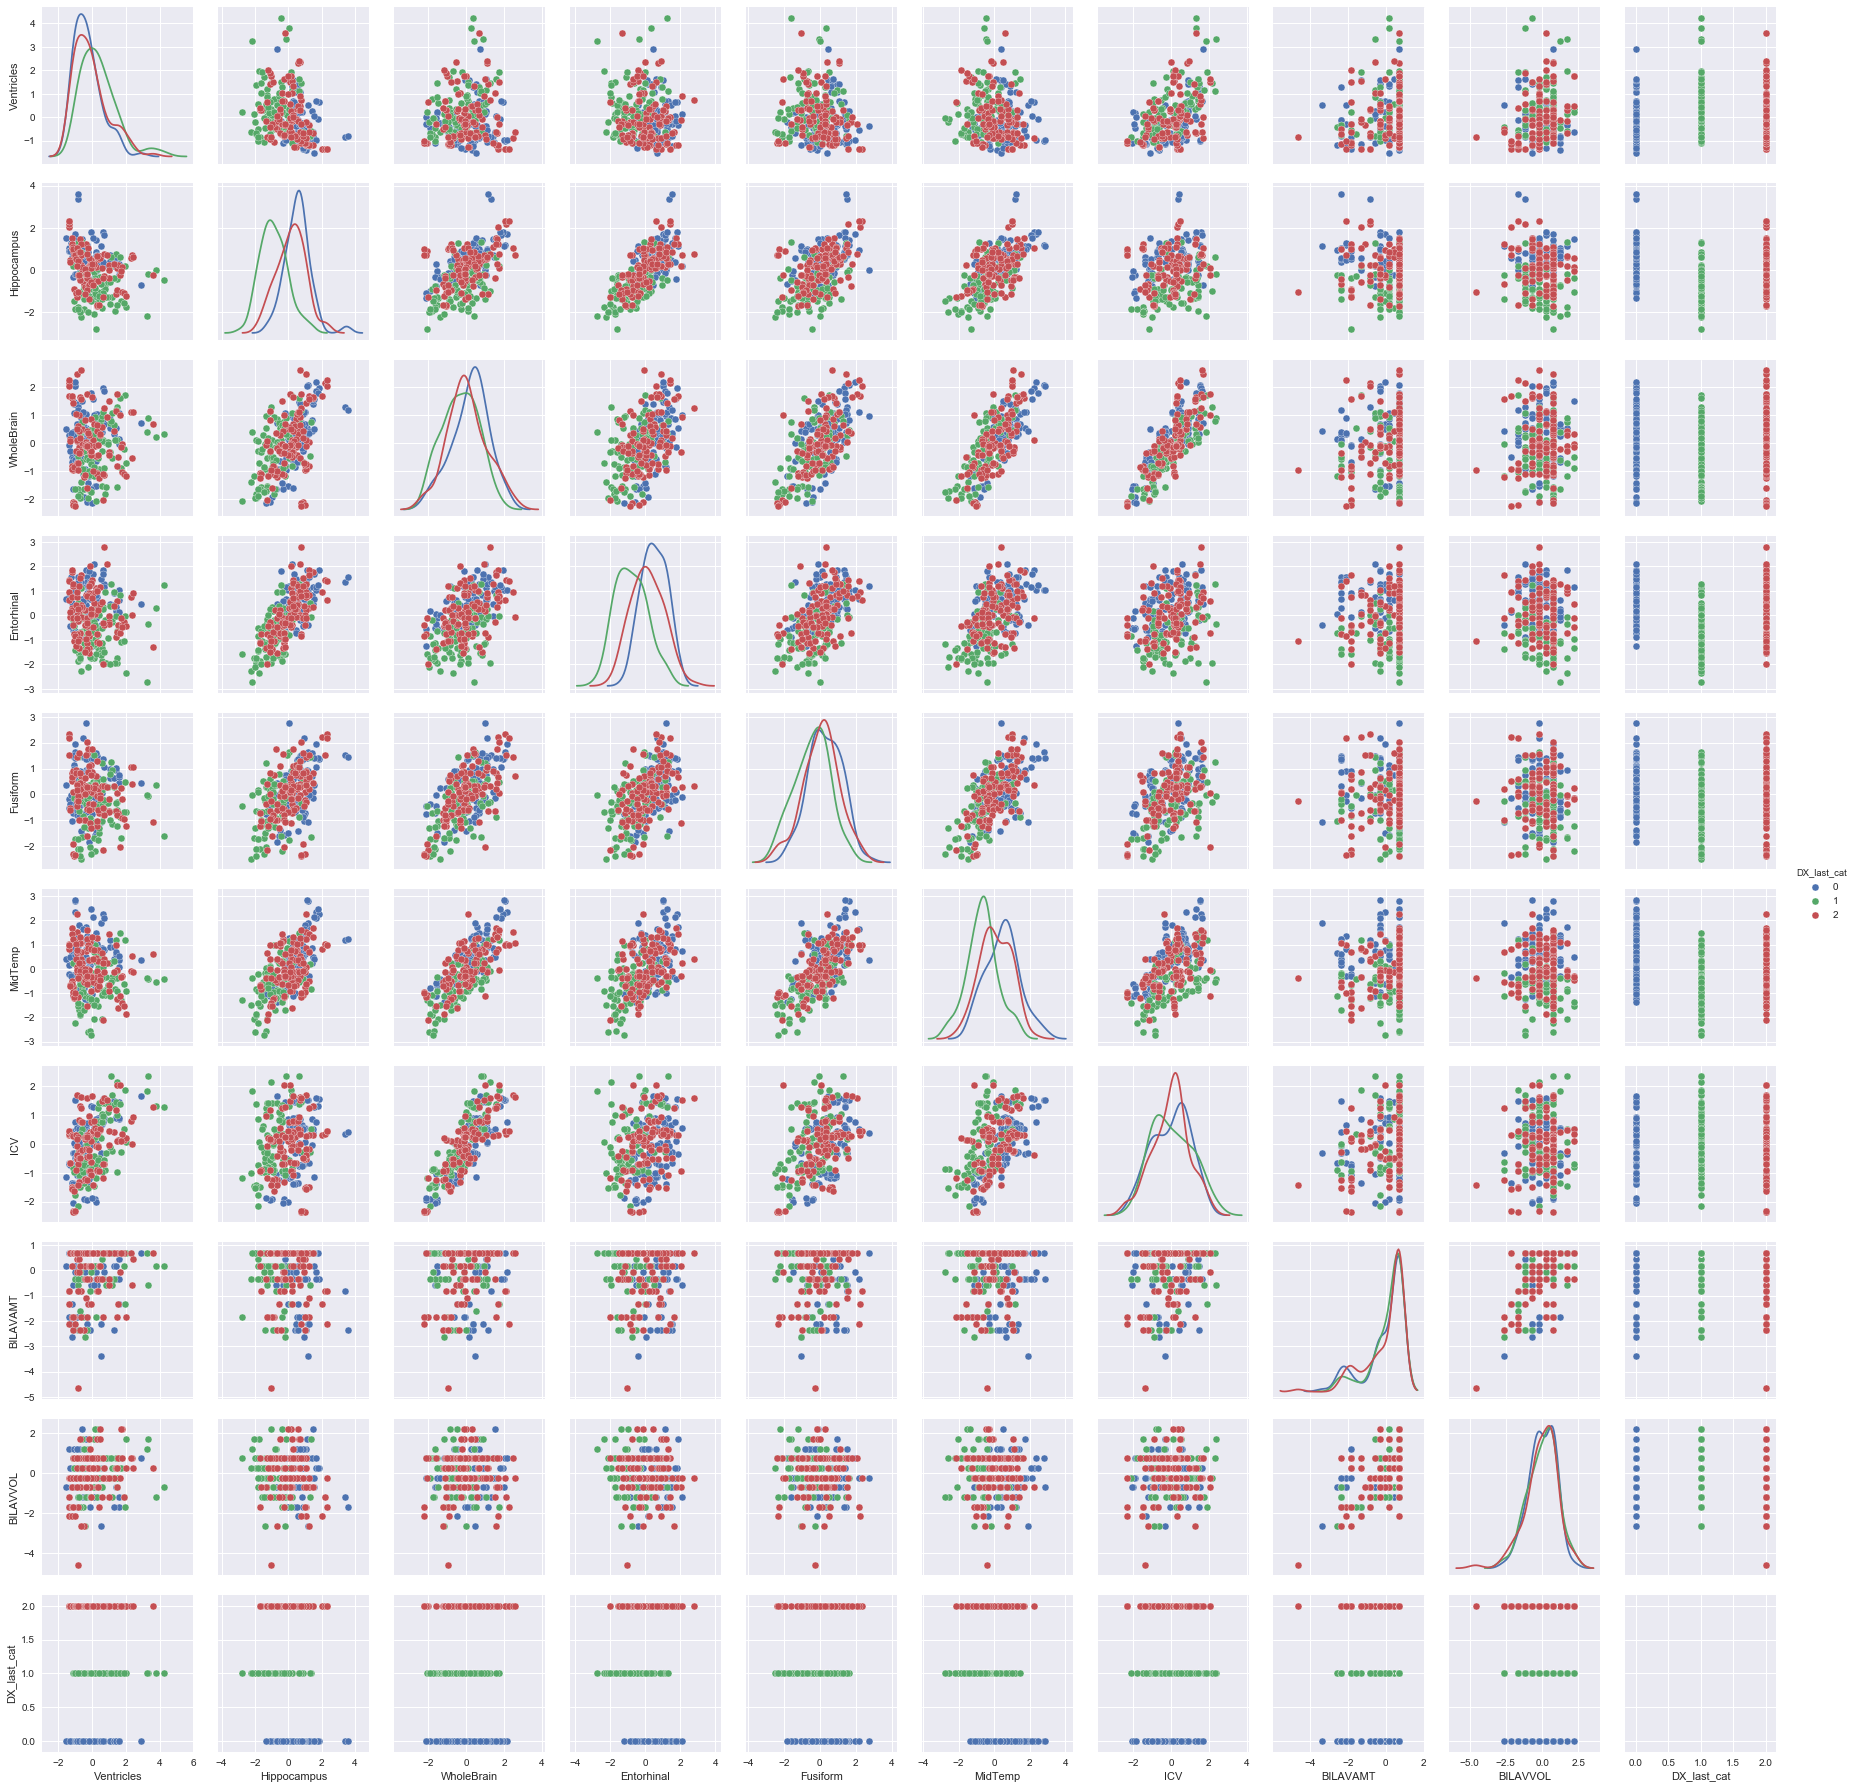

In [43]:
numerical_columns_plot_3= ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV',
                           'BILAVAMT','BILAVVOL','DX_last_cat']
sns.pairplot(data_train, vars=numerical_columns_plot_3, hue="DX_last_cat", size=2.5, diag_kind='kde');

## based on above three pairwise plot, some predictors shows strong correlation between, some also shows clear regin between classes.

## 2.2 train model over ADNI1 and test on ADNI1 , ADNI2, and ADNIGO. baseline model is logistic regression model, tuned by cross validation. multinomial and OvR, LDA, QDA, KNN and decsion tree are tried. with base model and decision tree the best performance. depth =2. only three predictors are needed, which fit the need to find the most effective way to diagnose.

In [43]:
#get X_train and y_train, X_test, y_test
X_train=copy.copy(data_train)
X_train=X_train.drop('DX_last_cat',axis=1)
y_train=copy.copy(data_train['DX_last_cat'])


X_test=copy.copy(data_test)
X_test=X_test.drop('DX_last_cat',axis=1)

y_test=copy.copy(data_test['DX_last_cat'])

#getting ADNI2 ANDIGO as test dataset
X_test_ADNI2=copy.copy(df_ADNI2)
X_test_ADNI2=X_test_ADNI2.drop('DX_last_cat',axis=1)
y_test_ADNI2=copy.copy(df_ADNI2['DX_last_cat'])

X_test_ADNIGO=copy.copy(df_ADNIGO)
X_test_ADNIGO=X_test_ADNIGO.drop('DX_last_cat',axis=1)

y_test_ADNIGO=copy.copy(df_ADNIGO['DX_last_cat'])




In [44]:
#debug
X_train.to_csv('data/X_train_DX_change.csv')
X_test.to_csv('data/X_test_DX_change.csv')

y_train.to_csv('data/y_train_DX_change.csv')
y_test.to_csv('data/y_test_DX_change.csv')


X_test_ADNI2.to_csv('data/X_test_ADNI2_DX_change.csv')
X_test_ADNIGO.to_csv('data/X_test_ADNIGO_DX_change.csv')

y_test_ADNI2.to_csv('data/y_test_ADNI2_DX_change.csv')
y_test_ADNIGO.to_csv('data/y_test_ADNIGO_DX_change.csv')

In [45]:
print(X_train.shape,X_test_ADNI2.shape)

(293, 49) (260, 49)


In [46]:
#run a logistic regression model with CV

logregcv = LogisticRegressionCV(penalty='l2',random_state = 123) 
result_log=logregcv.fit(X_train, y_train)
y_hat_train = logregcv.predict(X_train)
y_hat_test = logregcv.predict(X_test)
y_hat_test_ADNI2 = logregcv.predict(X_test_ADNI2)
y_hat_test_ADNIGO = logregcv.predict(X_test_ADNIGO)

print("logistic regression model:")
print("Train accuracy: ", accuracy_score(y_train, y_hat_train))
print("Test accuracy: ", accuracy_score(y_test, y_hat_test))
print("Test accuracy ADNI2: ", accuracy_score(y_test_ADNI2, y_hat_test_ADNI2))
print("Test accuracy ADNIGO: ", accuracy_score(y_test_ADNIGO, y_hat_test_ADNIGO))

logistic regression model:
Train accuracy:  0.959044368601
Test accuracy:  0.912052117264
Test accuracy ADNI2:  0.830769230769
Test accuracy ADNIGO:  0.78431372549


In [47]:
coef_list=pd.DataFrame(result_log.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])

class 0 top 3 predictors:
          c0         c1           c2             var
3  -6.06935    2.70725  -0.00262012           CDRSB
11 -2.32993   0.343071  -0.00367301             FAQ
24   1.9497 -0.0131246 -0.000149773  PTEDUCAT_cat_3
class 1 top 3 predictors:
           c0       c1           c2              var
3   -6.06935  2.70725  -0.00262012            CDRSB
31 -0.870134  -1.8027  0.000594349  PTEDUCAT_cat_10
6    1.13829 -1.71285   0.00292439             MMSE
class 2 top 3 predictors::
          c0        c1          c2    var
11 -2.32993  0.343071 -0.00367301    FAQ
6   1.13829  -1.71285  0.00292439   MMSE
3  -6.06935   2.70725 -0.00262012  CDRSB


In [48]:
print("logistic regression model:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

logistic regression model:
Confusion Matrix Train:
[[99  0  8]
 [ 0 84  3]
 [ 0  1 98]]
Confusion Matrix Test:
[[109   0  10]
 [  0  87   8]
 [  3   6  84]]
Confusion Matrix Test ADNI2:
[[111   0  31]
 [  0  39   6]
 [  3   4  66]]
Confusion Matrix Test ADNIGO:
[[17  0 10]
 [ 0  0  1]
 [ 0  0 23]]


In [49]:
#multinomial logistic regression with CV
logit_multi=LogisticRegressionCV(penalty='l2',multi_class='multinomial')
result_logit_multi=logit_multi.fit(X_train,y_train)

y_train_logit_multi_pred=result_logit_multi.predict(X_train)
y_test_logit_multi_pred=result_logit_multi.predict(X_test)

ytrain_pred = np.ravel(y_train_logit_multi_pred)
ytest_pred = np.ravel(y_test_logit_multi_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)

acc_rate_logit_mulit_train=accuracy_score(ytrain,ytrain_pred)
acc_rate_logit_mulit_test=accuracy_score(ytest,ytest_pred)


y_hat_test_ADNI2 = result_logit_multi.predict(X_test_ADNI2)
y_hat_test_ADNIGO = result_logit_multi.predict(X_test_ADNIGO)

acc_rate_logit_mulit_test_ADNI2=accuracy_score(y_test_ADNI2, y_hat_test_ADNI2)
acc_rate_logit_mulit_test_ADNIGO=accuracy_score(y_test_ADNIGO, y_hat_test_ADNIGO)

print("multinomial logistic regression: ")
print("Train accuracy: ",acc_rate_logit_mulit_train)
print("Test accuracy: ",acc_rate_logit_mulit_test)
print("Test accuracy ADNI2: ",acc_rate_logit_mulit_test_ADNI2)
print("Test accuracy ADNIGO: ",acc_rate_logit_mulit_test_ADNIGO)


multinomial logistic regression: 
Train accuracy:  0.931740614334
Test accuracy:  0.895765472313
Test accuracy ADNI2:  0.807692307692
Test accuracy ADNIGO:  0.764705882353


In [50]:
coef_list=pd.DataFrame(result_logit_multi.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])

class 0 top 3 predictors:
           c0        c1        c2    var
3   -2.11771    1.5556  0.562111  CDRSB
11 -0.952614  0.783317  0.169297    FAQ
6   0.714831 -0.861721   0.14689   MMSE
class 1 top 3 predictors:
           c0        c1        c2    var
3   -2.11771    1.5556  0.562111  CDRSB
6   0.714831 -0.861721   0.14689   MMSE
11 -0.952614  0.783317  0.169297    FAQ
class 2 top 3 predictors::
           c0        c1        c2              var
3   -2.11771    1.5556  0.562111            CDRSB
31 -0.143896 -0.362351  0.506247  PTEDUCAT_cat_10
21 -0.313136 -0.170646  0.483782   PTGENDER_cat_1


In [51]:
print("multinomial logistic regression: ")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

multinomial logistic regression: 
Confusion Matrix Train:
[[99  0  8]
 [ 0 84  3]
 [ 0  1 98]]
Confusion Matrix Test:
[[109   0  10]
 [  0  87   8]
 [  3   6  84]]
Confusion Matrix Test ADNI2:
[[107   0  35]
 [  0  37   2]
 [  7   6  66]]
Confusion Matrix Test ADNIGO:
[[17  0 11]
 [ 0  0  1]
 [ 0  0 22]]


In [52]:
#one-vs-rest (OvR) logistic regression with CV
logit_OvR=LogisticRegressionCV(penalty='l2',multi_class='ovr')
result_logit_OvR=logit_OvR.fit(X_train,y_train)

y_train_logit_OvR_pred=result_logit_OvR.predict(X_train)
y_test_logit_OvR_pred=result_logit_OvR.predict(X_test)

ytrain_pred = np.ravel(y_train_logit_OvR_pred)
ytest_pred = np.ravel(y_test_logit_OvR_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)

acc_rate_logit_OvR_train=accuracy_score(ytrain,ytrain_pred)
acc_rate_logit_OvR_test=accuracy_score(ytest,ytest_pred)


y_hat_test_ADNI2 = result_logit_OvR.predict(X_test_ADNI2)
y_hat_test_ADNIGO = result_logit_OvR.predict(X_test_ADNIGO)

acc_rate_logit_OvR_test_ADNI2=accuracy_score(y_test_ADNI2, y_hat_test_ADNI2)
acc_rate_logit_OvR_test_ADNIGO=accuracy_score(y_test_ADNIGO, y_hat_test_ADNIGO)

print("OvR logistic regression: ")
print("Train accuracy",acc_rate_logit_OvR_train)
print("Test accuracy",acc_rate_logit_OvR_test)

print("Train accuracy ADNI2",acc_rate_logit_OvR_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_logit_OvR_test_ADNIGO)


OvR logistic regression: 
Train accuracy 0.959044368601
Test accuracy 0.912052117264
Train accuracy ADNI2 0.830769230769
Test accuracy ADNIGO 0.78431372549


In [53]:
coef_list=pd.DataFrame(result_logit_OvR.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])

class 0 top 3 predictors:
          c0         c1           c2             var
3  -6.06935    2.70725  -0.00262012           CDRSB
11 -2.32993   0.343071  -0.00367301             FAQ
24   1.9497 -0.0131246 -0.000149773  PTEDUCAT_cat_3
class 1 top 3 predictors:
           c0       c1           c2              var
3   -6.06935  2.70725  -0.00262012            CDRSB
31 -0.870134  -1.8027  0.000594349  PTEDUCAT_cat_10
6    1.13829 -1.71285   0.00292439             MMSE
class 2 top 3 predictors::
          c0        c1          c2    var
11 -2.32993  0.343071 -0.00367301    FAQ
6   1.13829  -1.71285  0.00292439   MMSE
3  -6.06935   2.70725 -0.00262012  CDRSB


In [54]:
print("OvR logistic regression:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

OvR logistic regression:
Confusion Matrix Train:
[[99  0  8]
 [ 0 84  3]
 [ 0  1 98]]
Confusion Matrix Test:
[[109   0  10]
 [  0  87   8]
 [  3   6  84]]
Confusion Matrix Test ADNI2:
[[111   0  31]
 [  0  39   6]
 [  3   4  66]]
Confusion Matrix Test ADNIGO:
[[17  0 10]
 [ 0  0  1]
 [ 0  0 23]]


In [55]:
#LDA
lda = da.LinearDiscriminantAnalysis()
result_lda=lda.fit(X_train,y_train)

y_train_lda_pred=result_lda.predict(X_train)
y_test_lda_pred=result_lda.predict(X_test)

ytrain_pred = np.ravel(y_train_lda_pred)
ytest_pred = np.ravel(y_test_lda_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)

acc_rate_lda_train=result_lda.score(X_train,y_train)
acc_rate_lda_test=result_lda.score(X_test,y_test)

y_hat_test_ADNI2 = result_lda.predict(X_test_ADNI2)
y_hat_test_ADNIGO = result_lda.predict(X_test_ADNIGO)

acc_rate_lda_test_ADNI2=result_lda.score(X_test_ADNI2, y_test_ADNI2)
acc_rate_lda_test_ADNIGO=result_lda.score(X_test_ADNIGO, y_test_ADNIGO)


print("LDA: ")
print("Train accuracy",acc_rate_lda_train)
print("Test accuracy",acc_rate_lda_test)

print("Train accuracy ADNI2",acc_rate_lda_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_lda_test_ADNIGO)


LDA: 
Train accuracy 0.901023890785
Test accuracy 0.866449511401
Train accuracy ADNI2 0.738461538462
Test accuracy ADNIGO 0.627450980392


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [56]:
coef_list=pd.DataFrame(result_lda.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])

class 0 top 3 predictors:
          c0       c1        c2             var
38  6.10902 -4.53551   -2.0117  PTRACCAT_cat_1
42    5.931 -4.45957  -1.90923  PTRACCAT_cat_5
5  -5.40514  6.91037 -0.479569          ADAS13
class 1 top 3 predictors:
          c0       c1        c2             var
22  3.39064 -9.81916   4.57758  PTEDUCAT_cat_1
5  -5.40514  6.91037 -0.479569          ADAS13
24  5.33245 -6.37265  0.126266  PTEDUCAT_cat_3
class 2 top 3 predictors::
           c0        c1       c2              var
22   3.39064  -9.81916  4.57758   PTEDUCAT_cat_1
34  -3.72468  0.426943  3.05003  PTEDUCAT_cat_13
32 -0.550506  -3.09839  2.91618  PTEDUCAT_cat_11


In [57]:
print("LDA:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

LDA:
Confusion Matrix Train:
[[99  0  8]
 [ 0 84  3]
 [ 0  1 98]]
Confusion Matrix Test:
[[109   0  10]
 [  0  87   8]
 [  3   6  84]]
Confusion Matrix Test ADNI2:
[[90  1 36]
 [ 0 36  1]
 [24  6 66]]
Confusion Matrix Test ADNIGO:
[[14  0 15]
 [ 0  0  1]
 [ 3  0 18]]


In [58]:
#QDA
qda = da.QuadraticDiscriminantAnalysis()
result_qda=qda.fit(X_train,y_train)

y_train_qda_pred=result_qda.predict(X_train)
y_test_qda_pred=result_qda.predict(X_test)

ytrain_pred = np.ravel(y_train_qda_pred)
ytest_pred = np.ravel(y_test_qda_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)

y_test_qda_pred_ADNI2=result_qda.predict(X_test_ADNI2)
y_test_qda_pred_ADNIGO=result_qda.predict(X_test_ADNIGO)

#acc_rate_qda_train=accuarcy_rate(ytrain,ytrain_pred)
#acc_rate_qda_test=accuarcy_rate(ytest,ytest_pred)
acc_rate_qda_train=result_qda.score(X_train,y_train)
acc_rate_qda_test=result_qda.score(X_test,y_test)

acc_rate_qda_test_ADNI2=result_qda.score(X_test_ADNI2, y_test_ADNI2)
acc_rate_qda_test_ADNIGO=result_qda.score(X_test_ADNIGO, y_test_ADNIGO)

print("QDA: ")
print("Train accuracy",acc_rate_qda_train)
print("Test accuracy",acc_rate_qda_test)

print("Train accuracy ADNI2",acc_rate_qda_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_qda_test_ADNIGO)


QDA: 
Train accuracy 0.945392491468
Test accuracy 0.794788273616
Train accuracy ADNI2 0.269230769231
Test accuracy ADNIGO 0.450980392157


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [59]:
print("QDA:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_train_qda_pred, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_test_qda_pred, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_test_qda_pred_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_test_qda_pred_ADNIGO, y_test_ADNIGO))

QDA:
Confusion Matrix Train:
[[97  0 13]
 [ 0 85  1]
 [ 2  0 95]]
Confusion Matrix Test:
[[100   1  20]
 [  3  74  12]
 [  9  18  70]]
Confusion Matrix Test ADNI2:
[[ 9  0  2]
 [81 38 78]
 [24  5 23]]
Confusion Matrix Test ADNIGO:
[[12  0  1]
 [ 2  0 22]
 [ 3  0 11]]


In [60]:
#KNN
result_knn_list_cv=[]

for k in range (1,60):
#for k in range (1,60):
    item=[]
    #knn_temp = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    result_knn_temp=knn_temp.fit(X_train, np.ravel(y_train))

    #dt_cv = DecisionTreeClassifier(criterion='gini')
    #dt_cv.fit(X_train,y_train)
    #x=X_train
    scores=cross_val_score(result_knn_temp, X_train, np.ravel(y_train), cv=10)
    item.append(k)
    mean_temp=np.mean(scores)
    item.append(mean_temp)
    result_knn_list_cv.append(item)

result_knn_list_cv=pd.DataFrame(result_knn_list_cv)
result_knn_list_cv.columns=('knn-k','score')
print(result_knn_list_cv.sort_values('score',ascending=False)[0:10])   


    knn-k     score
23     24  0.762848
22     23  0.759285
26     27  0.752989
21     22  0.752618
48     49  0.751992
52     53  0.751877
51     52  0.751877
50     51  0.751877
24     25  0.749425
39     40  0.748914


In [61]:
  
knn = KNeighborsClassifier(n_neighbors=24)
result_knn=knn_temp.fit(X_train, np.ravel(y_train))

acc_rate_knn_train=result_knn.score(X_train,y_train)
acc_rate_knn_test=result_knn.score(X_test,y_test)

acc_rate_knn_test_ADNI2=result_knn.score(X_test_ADNI2,y_test_ADNI2)
acc_rate_knn_test_ADNIGO=result_knn.score(X_test_ADNIGO,y_test_ADNIGO)

print("KNN: ")
print("Train accuracy",acc_rate_knn_train)
print("Test accuracy",acc_rate_knn_test)

print("Train accuracy ADNI2",acc_rate_knn_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_knn_test_ADNIGO)

KNN: 
Train accuracy 0.778156996587
Test accuracy 0.778501628664
Train accuracy ADNI2 0.7
Test accuracy ADNIGO 0.509803921569


In [62]:
y_train_knn_pred=result_knn.predict(X_train)
y_test_knn_pred=result_knn.predict(X_test)
y_test_knn_pred_ADNI2=result_knn.predict(X_test_ADNI2)
y_test_knn_pred_ADNIGO=result_knn.predict(X_test_ADNIGO)

print("KNN:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_train_knn_pred, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_test_knn_pred, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_test_knn_pred_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_test_knn_pred_ADNIGO, y_test_ADNIGO))


KNN:
Confusion Matrix Train:
[[90  0 36]
 [ 0 74  9]
 [ 9 11 64]]
Confusion Matrix Test:
[[103   0  39]
 [  0  81   8]
 [  9  12  55]]
Confusion Matrix Test ADNI2:
[[109   1  64]
 [  0  35   1]
 [  5   7  38]]
Confusion Matrix Test ADNIGO:
[[17  0 24]
 [ 0  0  1]
 [ 0  0  9]]


In [63]:
#decision tree
depths = [i for i in range(2, 40)]
train_scores = []
test_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth)
    clf.fit(X_train,y_train)
    train_scores.append(clf.score(X_train,y_train))
    test_scores.append(clf.score(X_test,y_test))

print(pd.DataFrame(train_scores),pd.DataFrame(test_scores))

           0
0   0.897611
1   0.907850
2   0.928328
3   0.962457
4   0.979522
5   0.982935
6   0.982935
7   0.996587
8   1.000000
9   1.000000
10  1.000000
11  1.000000
12  1.000000
13  1.000000
14  1.000000
15  1.000000
16  1.000000
17  1.000000
18  1.000000
19  1.000000
20  1.000000
21  1.000000
22  1.000000
23  1.000000
24  1.000000
25  1.000000
26  1.000000
27  1.000000
28  1.000000
29  1.000000
30  1.000000
31  1.000000
32  1.000000
33  1.000000
34  1.000000
35  1.000000
36  1.000000
37  1.000000            0
0   0.908795
1   0.905537
2   0.859935
3   0.882736
4   0.863192
5   0.892508
6   0.879479
7   0.863192
8   0.876221
9   0.899023
10  0.892508
11  0.869707
12  0.866450
13  0.885993
14  0.889251
15  0.863192
16  0.876221
17  0.879479
18  0.882736
19  0.889251
20  0.872964
21  0.885993
22  0.863192
23  0.879479
24  0.866450
25  0.892508
26  0.869707
27  0.859935
28  0.869707
29  0.882736
30  0.863192
31  0.859935
32  0.872964
33  0.882736
34  0.872964
35  0.866450
36  0.882736

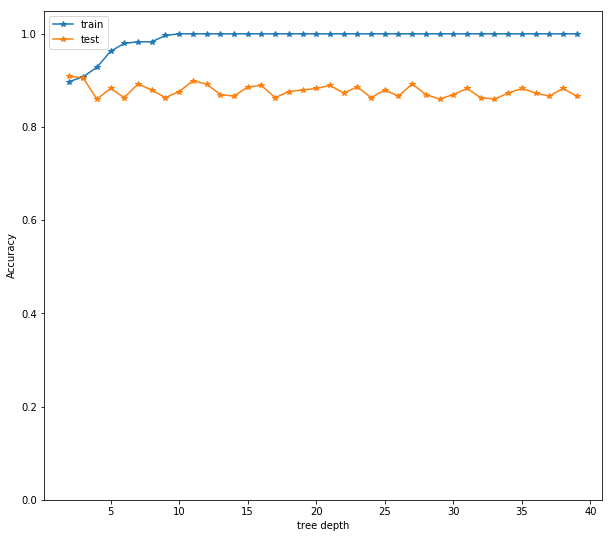

In [64]:
plt.figure(figsize=(10, 9))
plt.plot(depths, train_scores, '*-', label='train')
plt.plot(depths, test_scores, '*-', label='test')
plt.legend(loc='best')
plt.xlabel('tree depth')
plt.ylabel('Accuracy')
plt.ylim((0, 1.05))
plt.show()



In [65]:
clf = DecisionTreeClassifier(max_depth=2)
result_df=clf.fit(X_train, y_train)
print("Decision Tree:")
print ('Train score:', clf.score(X_train, y_train))
print ('Test score:', clf.score(X_test, y_test))
print ('Test score ADNI2:', clf.score(X_test_ADNI2, y_test_ADNI2))
print ('Test score ADNIGO:', clf.score(X_test_ADNIGO, y_test_ADNIGO))

Decision Tree:
Train score: 0.897610921502
Test score: 0.908794788274
Test score ADNI2: 0.903846153846
Test score ADNIGO: 0.921568627451


In [66]:
y_train_df_pred=result_df.predict(X_train)
y_test_df_pred=result_df.predict(X_test)
y_test_df_pred_ADNI2=result_df.predict(X_test_ADNI2)
y_test_df_pred_ADNIGO=result_df.predict(X_test_ADNIGO)

print("Decision Tree:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_train_df_pred, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_test_df_pred, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_test_df_pred_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_test_df_pred_ADNIGO, y_test_ADNIGO))


Decision Tree:
Confusion Matrix Train:
[[90  0  4]
 [ 0 74  6]
 [ 9 11 99]]
Confusion Matrix Test:
[[104   0   1]
 [  1  80   6]
 [  7  13  95]]
Confusion Matrix Test ADNI2:
[[101   0   1]
 [  0  37   5]
 [ 13   6  97]]
Confusion Matrix Test ADNIGO:
[[15  0  1]
 [ 0  0  1]
 [ 2  0 32]]


In [67]:
dotfile = open("data/dtree2_DX_change_nobfill_joinADNI_plasma.txt", 'w')
tree.export_graphviz(result_df, out_file = dotfile, feature_names = X_train.columns)
dotfile.close()